<a href="https://colab.research.google.com/github/OmdenaAI/KenyaRedCross/blob/main/Damage%20Assessment/Damage_Assessment_based_on_Sentinel_2_SAVI_Indices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Damage Assessment using SAVI.

**What is Soil Adjusted Vegetation Index (SAVI) ?**

SAVI was designed to minimize soil brightness influences. It gas a soil adjustment factor L.

Formula of SAVI vegetation index:

SAVI = ((NIR – Red) / (NIR + Red + L)) x (1 + L)

Key fact: L is a variable. Its values range within -1 to 1, depending on the amount of green vegetation present in the area. To run the remote sensing analysis of areas with high green vegetation, L is set to zero (in which case SAVI index data will be equal to NDVI); whereas low green vegetation regions require L=1.

When to use: for analysis of young crops; for arid regions with sparse vegetation (less than 15% of total area) and exposed soil surfaces.

Resource: https://eos.com/blog/6-spectral-indexes-on-top-of-ndvi-to-make-your-vegetation-analysis-complete/

This notebook entails using the u-net model built to performing inference on the before images to create masks for different vegetation covers. In this case cropland, pastureland and forestland. The steps used are as follows:
1. Loading the u-net model:lcn_unet_resnet50.pkl
2. Loading the before images in .tif and creating an RGB image from it as a numpy array.
3. Using the model to predict the vegetation classes from the image.
4. creating masks for cropland, pastureland and forestland.
5. Calculating the SAVI diff and affected pixels for respective classses categorized by degree of damage.
6. Saving the data into .csv file for further/future analysis.
7. Performing further Exploratory Data Analysis(EDA) on the data.



### **Loading Necessary Dependencies**

In [2]:
#suppressing output of the cell
%%capture  
#installing necessary dependencies
!pip -q install geopandas
!pip -q install geojson
!pip -q install rasterio
!pip install fastai --upgrade

In [3]:
# importing libraries
import os
import json
import requests
import glob
from pathlib import Path

import geojson
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
from shapely.geometry import Point, Polygon
from rasterio.plot import show_hist


from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import time

from fastai.vision.all import *

from  IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

**Mounting Google Drive**

In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


### **Loading the Sentinel-2 Images from Google Drive**

In [5]:
#Directory for storage of sentinel 2 images
%cd '/content/drive/My Drive/Official Folder of Kenya Red Cross Desert Locust Project/Data/Sentinel_Data/dl_aoi/Kenya_AOI_224/Kenya_AOI_224_GeoTiff'

/content/drive/.shortcut-targets-by-id/12QHGizgz_g-tBWlzTcLz5dz_YOtWUXz8/Official Folder of Kenya Red Cross Desert Locust Project/Data/Sentinel_Data/dl_aoi/Kenya_AOI_224/Kenya_AOI_224_GeoTiff


In [6]:
#path to before sentinel images
#paths for the .tif images
data_path = 'Kenya_AOI_before_224_clean'
bf_data = Path(data_path)

#the tif images are stored in the paths list
bf_data = glob.glob(os.path.join(bf_data,'*.tif'))
bf_data[:5]

['Kenya_AOI_before_224_clean/kenya_aoi_before (1).tif',
 'Kenya_AOI_before_224_clean/kenya_aoi_before (55).tif',
 'Kenya_AOI_before_224_clean/kenya_aoi_before (53).tif',
 'Kenya_AOI_before_224_clean/kenya_aoi_before (52).tif',
 'Kenya_AOI_before_224_clean/kenya_aoi_before (51).tif']

In [7]:
#path to after sentiel images
#paths for the .tif images
data_path = 'Kenya_AOI_after_224_clean'
af_data = Path(data_path)

#the tif images are stored in the paths list
af_data = glob.glob(os.path.join(af_data,'*.tif'))
af_data[:5]

['Kenya_AOI_after_224_clean/kenya_aoi_after (9).tif',
 'Kenya_AOI_after_224_clean/kenya_aoi_after (1).tif',
 'Kenya_AOI_after_224_clean/kenya_aoi_after (2).tif',
 'Kenya_AOI_after_224_clean/kenya_aoi_after (3).tif',
 'Kenya_AOI_after_224_clean/kenya_aoi_after (4).tif']

In [ ]:
print("Length of bf data=", len(bf_data))
print("Length of af data=", len(af_data))

Length of bf data= 348
Length of af data= 348


In [ ]:
#How to extract the image ID
int(bf_data[0].split('(')[1].split(')')[0])

1

In [8]:
#using for loop and storing the items/images into a dictionary
folder = {}
bf_list = bf_data.copy()
af_list = af_data.copy()
#iterating through the images
for i in range(len(bf_data)):
  files = []  #holds the before and after images
  for  j in range(len(af_data)):
    #checking for equality, splitting by the first parantheses in the string
    if str(bf_data[i].split('(')[1]) == str(af_data[j].split('(')[1]):
      #extracting the image_Id from the image name
      key = bf_data[i].split('(')[1].split(')')[0]
      files = [bf_data[i],af_data[j]]
      folder[key] = files
      bf_list.remove(bf_data[i]) #removing the matcged image 
      af_list.remove(af_data[j])

print('The number of correctly matched images: ',len(folder.keys()))
print("The number of mismatched images are: ",len(bf_list))

The number of correctly matched images:  348
The number of mismatched images are:  0


### **Pixel-Wise Vegetation Classification & Damage Assessment Using SAVI**
Using the resnet model built to classify each pixel in the sentinel-2 images to its respective landcover type. See the notebooks on using the U-net model for classification for more details.


In [ ]:
def get_y_fn(x) :
  return path_lbl/f'{re.findall(r"(.*2018)[0-9]+_RGB", x.stem)[0]}_LC_10m.png'

In [ ]:
def segm_acc(input, target) :
  target = target.squeeze(1)
  return (input.argmax(dim=1)==torch.tensor(target)).float().mean()

In [ ]:
#loading the model from the drive
infer = load_learner('/content/drive/My Drive/Omdena Project/Model/lcn_unet_resnet50.pkl')

In [ ]:
def get_rgb(path) :
  red = rio.open(path).read(4) # B4
  green = rio.open(path).read(3) # B3
  blue = rio.open(path).read(2) # B2

  rgb = np.dstack((red, green, blue))

  # normalize and convert to range 0-255
  rgb = ((rgb - rgb.min()) / (rgb.max() - rgb.min()) * 255).astype('uint8')
  return rgb

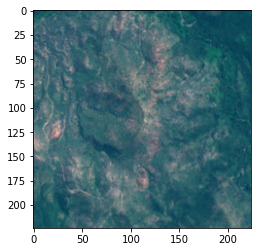

In [ ]:
im = get_rgb(folder['1'][0])
plt.imshow(im)

**Damage Assessment using SAVI difference**

The idea is to use the SAVI difference to categorize the pixels by the degree of damage. The following approach has been used:
- low damage - SAVI 0.01 to 0.2
- Moderate damage - SAVI > 0.2 to < 0.5
- High damage - SAVI > 0.5

In [ ]:
def veg_calc(mask,degree):
  #getting the total area of damage
  if degree == 'total':
    total = 0
    for i in range(mask.shape[0]):
      for j in range(mask.shape[0]):
          if mask[i][j] >= 0.01:
              total += 1

    return total * 0.01

  # calculating the areas with low damage
  elif degree == 'low':
    low = 0
    for i in range(mask.shape[0]):
        for j in range(mask.shape[0]):
            if mask[i][j] >= 0.01 and mask[i][j] <0.2 :
                low += 1

    return low *0.01
  
  #calculating the total area in Hectares(Ha) with moderate damage
  elif degree == 'moderate':
    moderate = 0
    for i in range(mask.shape[0]):
        for j in range(mask.shape[0]):
          #NDVI difference between 0.2 to 0.5
          if mask[i][j] >= 0.2 and mask[i][j] <0.5 :
                moderate += 1

    return moderate * 0.01

  #calculating the total area with high damage
  elif degree == 'high':
    high = 0
    for i in range(mask.shape[0]):
      for j in range(mask.shape[0]):
          if mask[i][j] >= 0.5:
              high += 1

    return high * 0.01


*Caution:This section takes very long to execute: about 60 minutes. Better ways to optimize the code can be explored.*

In [ ]:
#Measuring the time taken for execution
# store starting time 
begin = time.time() 
#Parameters
numMismatch = [] #holding the folder_Ids for mismateched images

#Creating a dataframe for storing the ndvi values
veg_df = pd.DataFrame(columns = ["Image_ID", "Total_Cropland(Ha)", 'Total_Pastureland(Ha)', "Total_Forestland(Ha)",
                                 'Low_Damage_Cropland(Ha)','Moderate_Damage_Cropland(Ha)','High_Damage_Cropland(Ha)',
                                 'Low_Damage_Pastureland(Ha)','Moderate_Damage_Pastureland(Ha)','High_Damage_Pastureland(Ha)',
                                 'Low_Damage_Forestland(Ha)','Moderate_Damage_Forestland(Ha)','High_Damage_Forestland(Ha)'

                                 ])

#iterating through all the images in the folder
for key in folder:
  #loading image from tif file using rasterio
  bf = rio.open(folder[key][0])
  af = rio.open(folder[key][1])

  # reading the RGB band from the image
  red = bf.read(4) # B4
  green = bf.read(3) # B3
  blue = bf.read(2) # B2

  rgb = np.dstack((red, green, blue))

  # normalize and convert to range 0-255
  rgb = ((rgb - rgb.min()) / (rgb.max() - rgb.min()) * 255).astype('uint8')

  #getting the masks from the rgb image
  pred = infer.predict(rgb)[0].numpy()

  #creating the masks for the vegatation classes: Cropland, Pastureland and Forestland
  crop_mask = pred==1
  pasture_mask = pred==2
  forest_mask = pred==5
  
  # Calculating SAVI from the pair of images
  L = 1 #defining parameters
  bf_red = bf.read(4)
  bf_nir = bf.read(8)
  af_red = af.read(4)
  af_nir = af.read(8)

  bf_savi = ((bf_nir.astype(float)-bf_red.astype(float))/(bf_nir.astype(float) + bf_red.astype(float) + L)) * (1 + L)
  af_savi = ((af_nir.astype(float)-af_red.astype(float))/(af_nir.astype(float) + af_red.astype(float) + L)) * (1 + L)

  #checking for mismatch 
  if (bf_savi.shape!=af_savi.shape):
      #print("Mismatch found!bf_nvdi shape = ",bf_ndvi.shape, ", af_nvdi shape = ",af_ndvi.shape)
      numMismatch.append(key)
      continue
  else :
    #calculating the SAVI difference
    diff_savi = bf_savi - af_savi

    #getting the SAVI difference in the various vegatation covers
    cropland_mask = np.multiply(diff_savi,crop_mask)
    pastureland_mask = np.multiply(diff_savi,pasture_mask)
    forestland_mask = np.multiply(diff_savi,forest_mask)

    #Getting the area affected for the different vegetation covers
    
    #Saving the data into a dataframe
    veg_df = veg_df.append({"Image_ID": key, 
                            "Total_Cropland(Ha)": veg_calc(cropland_mask,'total'), 
                            'Total_Pastureland(Ha)':veg_calc(pastureland_mask,'total'),
                            "Total_Forestland(Ha)":veg_calc(forestland_mask,'total'),
                            'Low_Damage_Cropland(Ha)':veg_calc(cropland_mask,'low'),
                            'Moderate_Damage_Cropland(Ha)':veg_calc(cropland_mask,'moderate'),
                            'High_Damage_Cropland(Ha)':veg_calc(cropland_mask,'high'),
                            'Low_Damage_Pastureland(Ha)':veg_calc(pastureland_mask,'low'),
                            'Moderate_Damage_Pastureland(Ha)':veg_calc(pastureland_mask,'moderate'),
                            'High_Damage_Pastureland(Ha)':veg_calc(pastureland_mask,'high'),
                            'Low_Damage_Forestland(Ha)':veg_calc(forestland_mask,'low'),
                            'Moderate_Damage_Forestland(Ha)':veg_calc(forestland_mask,'moderate'),
                            'High_Damage_Forestland(Ha)':veg_calc(forestland_mask,'high')},
                              ignore_index = True)

# store end time 
end = time.time() 
print("Number of cases where bf_savi shape is not equal to af_savi=", len(numMismatch))
# total time taken 
print(f"Total runtime of the program is {end - begin}") 

Number of cases where bf_savi shape is not equal to af_savi= 0
Total runtime of the program is 3403.8798542022705


In [ ]:
veg_df.head()

,Image_ID,Total_Cropland(Ha),Total_Pastureland(Ha),Total_Forestland(Ha),Low_Damage_Cropland(Ha),Moderate_Damage_Cropland(Ha),High_Damage_Cropland(Ha),Low_Damage_Pastureland(Ha),Moderate_Damage_Pastureland(Ha),High_Damage_Pastureland(Ha),Low_Damage_Forestland(Ha),Moderate_Damage_Forestland(Ha),High_Damage_Forestland(Ha)
0,1,0.00,16.73,105.55,0.00,0.00,0.00,4.19,12.39,0.15,17.34,81.49,6.72
1,55,28.76,50.57,42.76,27.67,1.02,0.07,48.72,1.83,0.02,31.60,11.15,0.01
2,53,0.00,234.27,12.04,0.00,0.00,0.00,232.69,1.58,0.00,11.98,0.06,0.00
3,52,0.00,358.34,3.06,0.00,0.00,0.00,356.49,1.85,0.00,3.06,0.00,0.00
4,51,0.00,64.76,3.25,0.00,0.00,0.00,59.43,5.33,0.00,3.00,0.25,0.00


### Identifying the Counties the Images Were Taken From.

In [9]:
#loading the file with the Kenyan Adminstration boundaries
file_path = '/content/drive/My Drive/Omdena Project/Data/geoboundary.geojson'
#reading the json file using geopandas
geoboundary = gpd.read_file(file_path)
geoboundary.head()

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
0,Bomet,KE-02,KEN-ADM1-3_0_0-B1,KEN,ADM1,"MULTIPOLYGON (((35.58631 -0.58674, 35.58790 -0.58973, 35.58429 -0.59065, 35.56312 -0.59694, 35.55525 -0.59921, 35.50532 -0.61366, 35.49750 -0.61616, 35.49372 -0.61757, 35.43574 -0.63423, 35.42450 -0.63765, 35.40491 -0.64326, 35.39850 -0.64564, 35.39893 -0.64888, 35.40174 -0.65504, 35.40430 -0.66255, 35.40894 -0.67354, 35.40992 -0.67665, 35.41273 -0.68434, 35.42310 -0.71144, 35.42450 -0.71577, 35.42670 -0.72114, 35.43030 -0.72383, 35.43635 -0.72877, 35.44031 -0.73176, 35.44410 -0.73494, 35.46650 -0.75264, 35.46991 -0.75514, 35.47352 -0.75825, 35.47974 -0.76307, 35.48853 -0.76674, 35.49213 -..."
1,Kisii,KE-16,KEN-ADM1-3_0_0-B2,KEN,ADM1,"MULTIPOLYGON (((35.00129 -0.89357, 34.98792 -0.89686, 34.98249 -0.89796, 34.97529 -0.90034, 34.95850 -0.90376, 34.95472 -0.90468, 34.94312 -0.90846, 34.92951 -0.91127, 34.91810 -0.91395, 34.89252 -0.92055, 34.88910 -0.92158, 34.85010 -0.93117, 34.84491 -0.93385, 34.83149 -0.93586, 34.79731 -0.94453, 34.78089 -0.94917, 34.77710 -0.94966, 34.76069 -0.95466, 34.75031 -0.95643, 34.69770 -0.96925, 34.67750 -0.97346, 34.67450 -0.97304, 34.67109 -0.97285, 34.66669 -0.97316, 34.66395 -0.97255, 34.66034 -0.97108, 34.65650 -0.96895, 34.65149 -0.96693, 34.64692 -0.96748, 34.64350 -0.96907, 34.63849 -..."
2,Narok,KE-33,KEN-ADM1-3_0_0-B3,KEN,ADM1,"MULTIPOLYGON (((36.34809 -1.17494, 36.33735 -1.18696, 36.29114 -1.23665, 36.28809 -1.23866, 36.28052 -1.24824, 36.26954 -1.26027, 36.25831 -1.27223, 36.24811 -1.28364, 36.23169 -1.30104, 36.22870 -1.30385, 36.21833 -1.31514, 36.19935 -1.33485, 36.19611 -1.33845, 36.18909 -1.34553, 36.16572 -1.37056, 36.16291 -1.37324, 36.15510 -1.38136, 36.14429 -1.39296, 36.14210 -1.39503, 36.13691 -1.40046, 36.13294 -1.40498, 36.12653 -1.41157, 36.12171 -1.41585, 36.11854 -1.42018, 36.07514 -1.46577, 36.07075 -1.46876, 36.06849 -1.47285, 36.05732 -1.48445, 36.05311 -1.48915, 36.04969 -1.49238, 36.05872 -..."
3,Homa Bay,KE-08,KEN-ADM1-3_0_0-B4,KEN,ADM1,"MULTIPOLYGON (((35.02112 -0.41048, 35.02131 -0.41427, 35.01410 -0.41829, 35.00471 -0.42610, 35.00171 -0.42879, 34.99909 -0.43050, 34.98951 -0.43428, 34.98653 -0.43625, 34.97834 -0.43862, 34.97309 -0.44100, 34.96753 -0.44319, 34.95875 -0.45113, 34.94953 -0.45882, 34.94349 -0.46260, 34.94261 -0.46367, 34.94092 -0.46572, 34.93710 -0.46755, 34.93635 -0.46791, 34.93435 -0.46860, 34.92994 -0.47011, 34.92792 -0.47219, 34.91834 -0.47701, 34.91230 -0.47982, 34.90754 -0.48232, 34.90210 -0.48403, 34.88489 -0.48830, 34.88111 -0.48909, 34.87592 -0.49202, 34.86310 -0.50416, 34.85871 -0.50551, 34.85590 -..."
4,Migori,KE-27,KEN-ADM1-3_0_0-B5,KEN,ADM1,"MULTIPOLYGON (((34.73151 -1.38936, 34.70255 -1.37307, 34.69872 -1.37089, 34.67765 -1.35889, 34.65625 -1.34688, 34.63429 -1.33439, 34.63116 -1.33262, 34.61698 -1.32478, 34.60169 -1.31508, 34.57645 -1.30183, 34.54749 -1.28554, 34.51490 -1.26745, 34.48911 -1.25266, 34.47528 -1.24451, 34.46843 -1.24081, 34.45767 -1.23491, 34.44595 -1.22806, 34.42549 -1.21656, 34.38630 -1.19417, 34.27509 -1.13145, 34.21062 -1.09520, 34.12052 -1.04458, 34.11591 -1.04158, 34.10794 -1.03708, 34.09316 -1.02875, 34.09070 -1.02736, 34.08033 -1.02186, 34.04609 -1.04585, 34.04090 -1.04616, 34.03754 -1.04518, 34.03412 -..."


In [ ]:
#how many counties are in the dataset?
geoboundary.shapeName.nunique()

47

In [ ]:
geoboundary.shapeName.unique()

array(['Bomet', 'Kisii', 'Narok', 'Homa Bay', 'Migori', 'Nakuru',
       'Kajiado', 'Kericho', 'Kisumu', 'Nyamira', 'Siaya', 'Busia',
       'Vihiga', 'Machakos', 'Makueni', 'Nairobi', 'Baringo', 'Bungoma',
       'Elegeyo-Marakwet', 'Embu', 'Garissa', 'Isiolo', 'Kakamega',
       'Kiambu', 'Kilifi', 'Kirinyaga', 'Kitui', 'Kwale', 'Laikipia',
       'Lamu', 'Mandera', 'Marsabit', 'Meru', 'Mombasa', 'Nandi',
       'Nyandarua', 'Nyeri', 'Samburu', 'Taita Taveta', 'Tana River',
       'Tharaka-Nithi', 'Trans Nzoia', 'Turkana', 'Uasin Gishu', 'Wajir',
       'West Pokot', 'Murang`a'], dtype=object)

In [10]:
#saving the county names into a list
counties = geoboundary.shapeName.unique().tolist()

# saving the ploygons into a list too
polygons = geoboundary.geometry.tolist()

#combining the two list into a dictinary
county_poly = dict(zip(counties,polygons))

In [ ]:
#testing it out to identify a point in Mandera, from the Locust Hub dataset
P1 = Point(40.91667, 2.80000)
for county,poly in county_poly.items():
  #print(county)
  if P1.within(poly):
    print(county)

Mandera


*The logic seems to work perfectly, the next step is to classify the images accroding to their respective counties.*

In [25]:
#getting the raster bounds
image = rio.open(folder['1'][0])

In [26]:
# testing it out with the rasters
image.bounds

BoundingBox(left=36.42012706947252, bottom=1.0200370051177166, right=36.440249331836796, top=1.040159267481994)

In [27]:
#getting the centre coordinate
X = image.bounds[0] + (image.bounds[2] - image.bounds[0])/2

Y = image.bounds[1] + (image.bounds[3] - image.bounds[1])/2

In [28]:
X,Y

(36.430188200654655, 1.0300981362998551)

In [29]:
P2 = Point(X,Y)
for county,poly in county_poly.items():
  #print(county)
  if P2.within(poly):
    print(county)

Turkana


*The logic also performs well on the rasters, the next stage is to go ahead and classify the rest of the images.*

In [32]:
#Creating a dataframe for storing the ndvi values
location_df = pd.DataFrame(columns = ["Image_ID","Latitude","Longitude","County"])

#iterating through all the images in the folder
for key in folder:
  #loading image from tif file using rasterio
  bf = rio.open(folder[key][0])

  #getting the centre coordinate
  X = bf.bounds[0] + (bf.bounds[2] - bf.bounds[0])/2 # X Coordinate or Longitude
  Y = bf.bounds[1] + (bf.bounds[3] - bf.bounds[1])/2 # Y Coordinate  or Latitude

  #the coordinates for the centre of the Area of Interest
  P = Point(X,Y)
  for county,poly in county_poly.items():
    #print(county)
    if P.within(poly):
      #Saving the data into the dataframe
      location_df = location_df.append({'Image_ID':key,'Latitude':Y,'Longitude':X,'County':county},ignore_index = True)

    else:
      pass
      #print('dnfj')
  

In [33]:
#image location dataframe
location_df.head()

,Image_ID,Latitude,Longitude,County
0,1,1.030098,36.430188,Turkana
1,55,3.121466,35.619638,Turkana
2,53,2.204825,35.801637,Turkana
3,52,2.191171,35.795259,Turkana
4,51,3.011512,35.887696,Turkana


In [ ]:
#merging the two data frames for NDVI difference and location
veg_loc_df = pd.merge(location_df,veg_df,on = 'Image_ID')
veg_loc_df.head()

,Image_ID,County,Total_Cropland(Ha),Total_Pastureland(Ha),Total_Forestland(Ha),Low_Damage_Cropland(Ha),Moderate_Damage_Cropland(Ha),High_Damage_Cropland(Ha),Low_Damage_Pastureland(Ha),Moderate_Damage_Pastureland(Ha),High_Damage_Pastureland(Ha),Low_Damage_Forestland(Ha),Moderate_Damage_Forestland(Ha),High_Damage_Forestland(Ha)
0,1,Turkana,0.00,16.73,105.55,0.00,0.00,0.00,4.19,12.39,0.15,17.34,81.49,6.72
1,55,Turkana,28.76,50.57,42.76,27.67,1.02,0.07,48.72,1.83,0.02,31.60,11.15,0.01
2,53,Turkana,0.00,234.27,12.04,0.00,0.00,0.00,232.69,1.58,0.00,11.98,0.06,0.00
3,52,Turkana,0.00,358.34,3.06,0.00,0.00,0.00,356.49,1.85,0.00,3.06,0.00,0.00
4,51,Turkana,0.00,64.76,3.25,0.00,0.00,0.00,59.43,5.33,0.00,3.00,0.25,0.00


In [ ]:
#saving the dataframe into csv file
veg_loc_df.to_csv('/content/drive/My Drive/Omdena Project/Data/damage_assessment_SAVI.csv',index = False)

### Exploratory Data Analysis (Damage Assessement_SAVI.csv data)

In [52]:
#loading the csv file - The File can can be found on the Data Folder from Github Repository
df = pd.read_csv('/content/drive/My Drive/Omdena Project/Data/damage_assessment_SAVI.csv')
df.head()

,Image_ID,Latitude,Longitude,County,Total_Cropland(Ha),Total_Pastureland(Ha),Total_Forestland(Ha),Low_Damage_Cropland(Ha),Moderate_Damage_Cropland(Ha),High_Damage_Cropland(Ha),Low_Damage_Pastureland(Ha),Moderate_Damage_Pastureland(Ha),High_Damage_Pastureland(Ha),Low_Damage_Forestland(Ha),Moderate_Damage_Forestland(Ha),High_Damage_Forestland(Ha)
0,1,1.030098,36.430188,Turkana,0.00,16.73,105.55,0.00,0.00,0.00,4.19,12.39,0.15,17.34,81.49,6.72
1,55,3.121466,35.619638,Turkana,28.76,50.57,42.76,27.67,1.02,0.07,48.72,1.83,0.02,31.60,11.15,0.01
2,53,2.204825,35.801637,Turkana,0.00,234.27,12.04,0.00,0.00,0.00,232.69,1.58,0.00,11.98,0.06,0.00
3,52,2.191171,35.795259,Turkana,0.00,358.34,3.06,0.00,0.00,0.00,356.49,1.85,0.00,3.06,0.00,0.00
4,51,3.011512,35.887696,Turkana,0.00,64.76,3.25,0.00,0.00,0.00,59.43,5.33,0.00,3.00,0.25,0.00


In [ ]:
df.columns[2:]

Index(['Total_Cropland(Ha)', 'Total_Pastureland(Ha)', 'Total_Forestland(Ha)',
       'Low_Damage_Cropland(Ha)', 'Moderate_Damage_Cropland(Ha)',
       'High_Damage_Cropland(Ha)', 'Low_Damage_Pastureland(Ha)',
       'Moderate_Damage_Pastureland(Ha)', 'High_Damage_Pastureland(Ha)',
       'Low_Damage_Forestland(Ha)', 'Moderate_Damage_Forestland(Ha)',
       'High_Damage_Forestland(Ha)'],
      dtype='object')

In [53]:
#grouping the data by county
county_df = pd.DataFrame(df.groupby('County')[df.columns[3:]].sum())
county_df.head()

,Total_Cropland(Ha),Total_Pastureland(Ha),Total_Forestland(Ha),Low_Damage_Cropland(Ha),Moderate_Damage_Cropland(Ha),High_Damage_Cropland(Ha),Low_Damage_Pastureland(Ha),Moderate_Damage_Pastureland(Ha),High_Damage_Pastureland(Ha),Low_Damage_Forestland(Ha),Moderate_Damage_Forestland(Ha),High_Damage_Forestland(Ha)
County,,,,,,,,,,,,
Baringo,79.15,217.99,543.34,68.28,9.93,0.94,188.44,25.31,4.24,450.63,73.68,19.03
Garissa,5.59,20.87,1.82,3.55,1.56,0.48,20.37,0.47,0.03,1.79,0.03,0.00
Isiolo,12.10,4171.40,1627.14,10.34,1.74,0.02,3669.34,498.33,3.73,1299.51,323.02,4.61
Kericho,144.33,0.01,0.28,87.07,50.64,6.62,0.01,0.00,0.00,0.26,0.02,0.00
Kirinyaga,3.73,23.27,278.95,2.80,0.25,0.68,16.63,1.84,4.80,149.53,60.58,68.84


In [ ]:
#calculating the total vegetation damage per county
county_df['Total_Damage(Ha)'] = county_df['Total_Cropland(Ha)'] + county_df['Total_Pastureland(Ha)'] + county_df['High_Damage_Cropland(Ha)'] + county_df['Total_Forestland(Ha)']
county_df.head()

,Total_Cropland(Ha),Total_Pastureland(Ha),Total_Forestland(Ha),Low_Damage_Cropland(Ha),Moderate_Damage_Cropland(Ha),High_Damage_Cropland(Ha),Low_Damage_Pastureland(Ha),Moderate_Damage_Pastureland(Ha),High_Damage_Pastureland(Ha),Low_Damage_Forestland(Ha),Moderate_Damage_Forestland(Ha),High_Damage_Forestland(Ha),Total_Damage(Ha)
County,,,,,,,,,,,,,
Baringo,79.15,217.99,543.34,68.28,9.93,0.94,188.44,25.31,4.24,450.63,73.68,19.03,841.42
Garissa,5.59,20.87,1.82,3.55,1.56,0.48,20.37,0.47,0.03,1.79,0.03,0.00,28.76
Isiolo,12.10,4239.57,1662.76,10.34,1.74,0.02,3736.11,499.73,3.73,1332.43,325.72,4.61,5914.45
Kericho,144.33,0.01,0.28,87.07,50.64,6.62,0.01,0.00,0.00,0.26,0.02,0.00,151.24
Kirinyaga,3.73,23.27,278.95,2.80,0.25,0.68,16.63,1.84,4.80,149.53,60.58,68.84,306.63


In [ ]:
# sorting the dataframe by total damage
county_df = county_df.sort_values('Total_Damage(Ha)', ascending = False)
county_df.head()

,Total_Cropland(Ha),Total_Pastureland(Ha),Total_Forestland(Ha),Low_Damage_Cropland(Ha),Moderate_Damage_Cropland(Ha),High_Damage_Cropland(Ha),Low_Damage_Pastureland(Ha),Moderate_Damage_Pastureland(Ha),High_Damage_Pastureland(Ha),Low_Damage_Forestland(Ha),Moderate_Damage_Forestland(Ha),High_Damage_Forestland(Ha),Total_Damage(Ha)
County,,,,,,,,,,,,,
Turkana,1335.81,19885.68,1309.84,1227.87,76.40,31.54,18582.54,1293.19,9.95,999.16,299.61,11.07,22562.87
Marsabit,132.08,12535.41,1662.58,119.81,11.92,0.35,9838.76,2555.62,141.03,1207.72,403.15,51.71,14330.42
Samburu,73.15,6748.18,2287.07,70.99,1.84,0.32,6248.54,485.19,14.45,1563.23,709.31,14.53,9108.72
Isiolo,12.10,4239.57,1662.76,10.34,1.74,0.02,3736.11,499.73,3.73,1332.43,325.72,4.61,5914.45
Laikipia,2426.12,1226.73,634.91,790.34,1210.79,424.99,469.33,719.17,38.23,172.65,416.04,46.22,4712.75


In [ ]:
county_df.dtypes

Total_Cropland(Ha)                 float64
Total_Pastureland(Ha)              float64
Total_Forestland(Ha)               float64
Low_Damage_Cropland(Ha)            float64
Moderate_Damage_Cropland(Ha)       float64
High_Damage_Cropland(Ha)           float64
Low_Damage_Pastureland(Ha)         float64
Moderate_Damage_Pastureland(Ha)    float64
High_Damage_Pastureland(Ha)        float64
Low_Damage_Forestland(Ha)          float64
Moderate_Damage_Forestland(Ha)     float64
High_Damage_Forestland(Ha)         float64
Total_Damage(Ha)                   float64
dtype: object

**Distribution of vegetation loss in the counties categorized by vegatation class**

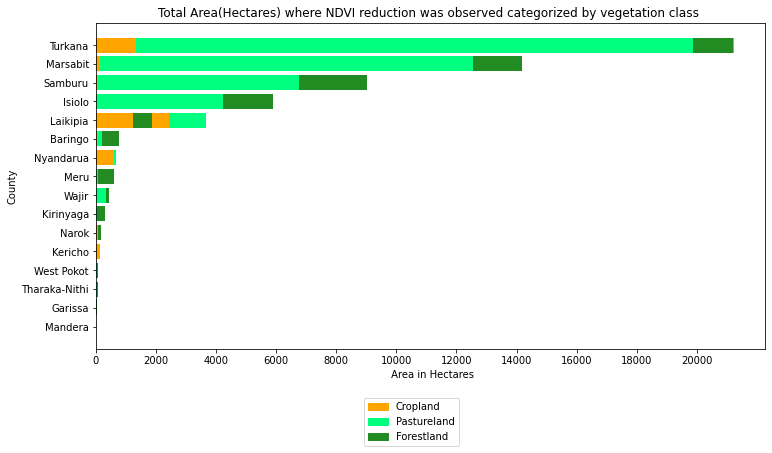

In [ ]:
#color map for the vegetation classes
labels = {0:'Cropland', 1:'Pastureland', 2:'Forestland'}
colors = {0:'orange', 1:'springgreen',2:'forestgreen'}
patches = [ mpatches.Patch(color=colors[i], label=f'{labels[i]}') for i in range(len(labels)) ]

# sorting the dataframe by total damage
county_df = county_df.sort_values('Total_Damage(Ha)', ascending = True)

# creating a stacked bar plot visualization
fig,ax = plt.subplots(figsize = (12,6))
ax.barh(y= county_df.index,width =  county_df['Total_Cropland(Ha)'].values,height = 0.8, color = 'orange')
ax.barh(y = county_df.index, width = county_df['Total_Pastureland(Ha)'],height = 0.8, left =county_df['Total_Cropland(Ha)'].values,color = 'springgreen')
ax.barh(y = county_df.index, width = county_df['Total_Forestland(Ha)'].values,height = 0.8, left =county_df['Total_Pastureland(Ha)'].values,color = 'forestgreen')

ax.set_xticks(np.arange(0,22000,2000))
ax.set_yticks(np.arange(len(county_df.index)))

#labelling the figure
plt.title('Total Area(Hectares) where NDVI reduction was observed categorized by vegetation class ')
plt.xlabel(' Area in Hectares')
plt.ylabel('County')
#ax.xaxis.grid()

#creating a legend
plt.legend(handles=patches, bbox_to_anchor=(0.4, -0.15), loc=2, borderaxespad=0. )

#plt.savefig('/content/drive/My Drive/Omdena Project/Visualizations_Damage_Assessment/Vegetation_class_dist.png', dpi=200, bbox_inches='tight', pad_inches=0.7)
plt.show();

**Which Vegetation Class was affected the most?**

In [ ]:
county_df['Total_Cropland(Ha)'].sum(),county_df['Total_Pastureland(Ha)'].sum(),county_df['Total_Forestland(Ha)'].sum()

(4899.76, 45546.01999999999, 9148.839999999998)

In [ ]:
county_df['Total_Cropland(Ha)'].sum()+ county_df['Total_Pastureland(Ha)'].sum()+county_df['Total_Forestland(Ha)'].sum()

59594.61999999999

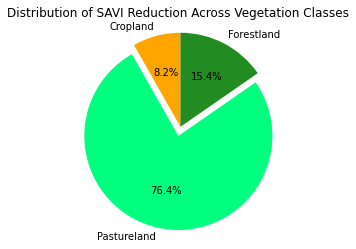

In [ ]:
#labels
labels = ['Cropland','Pastureland','Forestland']
#the summation for all affected areas 
total_area = [county_df['Total_Cropland(Ha)'].sum(),county_df['Total_Pastureland(Ha)'].sum(),county_df['Total_Forestland(Ha)'].sum()]
explode = (0, 0.1, 0)  # only "explode" the 2nd slice 
#plotting the piechart
fig1, ax1 = plt.subplots()
ax1.pie(total_area, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False,colors= ['orange','springgreen','forestgreen'], startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Distribution of SAVI Reduction Across Vegetation Classes')

#plt.savefig('/content/drive/My Drive/Omdena Project/Visualizations_Damage_Assessment/pie_chart.png', dpi=200, bbox_inches='tight', pad_inches=0.7)
plt.show();

**Assessing the Degree of Damage for Cropland**

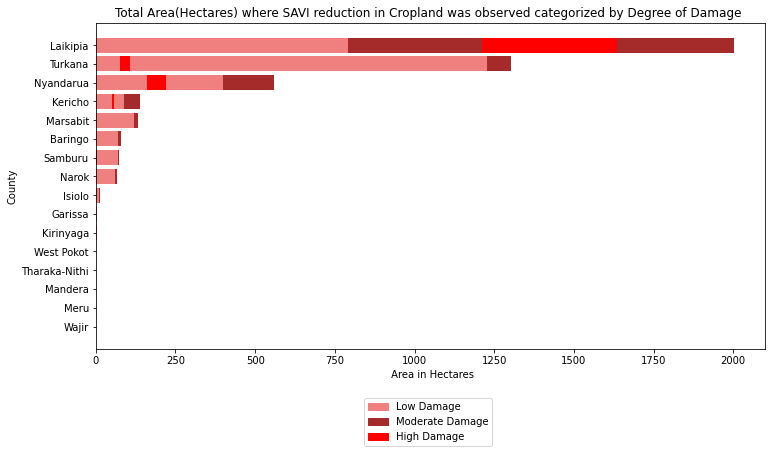

In [ ]:
#color map for the degree of damage
labels = {0:'Low Damage', 1:'Moderate Damage', 2:'High Damage'}
colors = {0:'lightcoral', 1:'brown',2:'red'}
patches = [ mpatches.Patch(color=colors[i], label=f'{labels[i]}') for i in range(len(labels)) ]

# sorting the dataframe by total damage
county_df = county_df.sort_values('Total_Cropland(Ha)', ascending = True)

# creating a stacked bar plot visualization
fig = plt.figure(figsize = (12,6))
plt.barh(county_df.index, county_df['Low_Damage_Cropland(Ha)'],height = 0.8, color = 'lightcoral')
plt.barh(county_df.index, county_df['Moderate_Damage_Cropland(Ha)'],height = 0.8, left =county_df['Low_Damage_Cropland(Ha)'],color = 'brown')
plt.barh(county_df.index, county_df['High_Damage_Cropland(Ha)'],height = 0.8, left =county_df['Moderate_Damage_Cropland(Ha)'],color = 'red')

#labelling the figure
plt.title('Total Area(Hectares) where SAVI reduction in Cropland was observed categorized by Degree of Damage ')
plt.xlabel(' Area in Hectares')
plt.ylabel('County')

#creating a legend
plt.legend(handles=patches, bbox_to_anchor=(0.4, -0.15), loc=2, borderaxespad=0. )

#plt.savefig('/content/drive/My Drive/Omdena Project/Visualizations_Damage_Assessment/crop_damage.png', dpi=200, bbox_inches='tight', pad_inches=0.7)
plt.show();

In [ ]:
 Total_Degree_Crop = [county_df['Low_Damage_Cropland(Ha)'].sum(), county_df['Moderate_Damage_Cropland(Ha)'].sum(), county_df['High_Damage_Cropland(Ha)'].sum()]
 Total_Degree_Crop

[2843.34, 1530.3500000000001, 526.07]

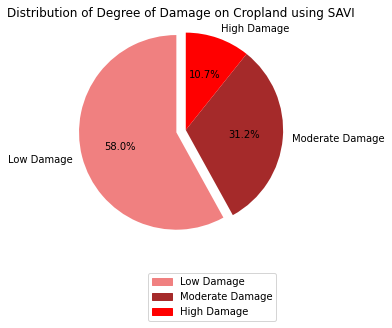

In [ ]:
#labels
labels = ['Low Damage','Moderate Damage','High Damage']

explode = (0.1, 0, 0)  # only "explode" the 2nd slice 
#plotting the piechart
fig1, ax1 = plt.subplots()
ax1.pie(Total_Degree_Crop, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False,colors= ['lightcoral','brown','red'], startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Distribution of Degree of Damage on Cropland using SAVI')

plt.legend(handles=patches, bbox_to_anchor=(0.4, -0.15), loc=2, borderaxespad=0. )

#plt.savefig('/content/drive/My Drive/Omdena Project/Visualizations_Damage_Assessment/degree_damage_pie_chart.png', dpi=200, bbox_inches='tight', pad_inches=0.7)
plt.show();

**Assessing the Degree of Damage for Pastureland**

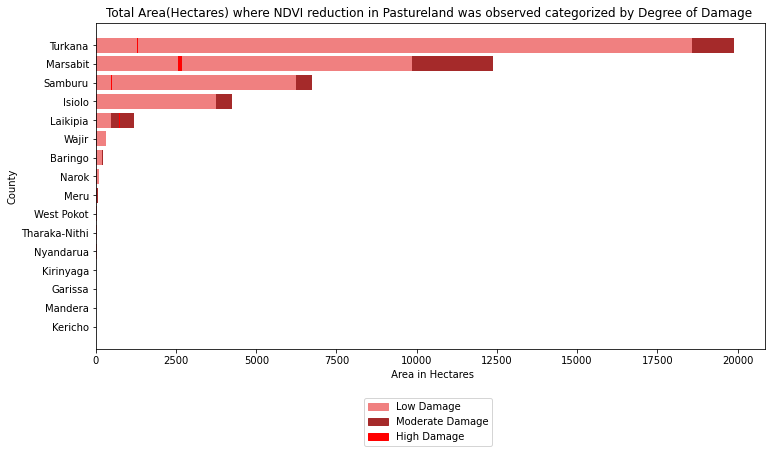

In [ ]:
#color map for the degree of damage
labels = {0:'Low Damage', 1:'Moderate Damage', 2:'High Damage'}
colors = {0:'lightcoral', 1:'brown',2:'red'}
patches = [ mpatches.Patch(color=colors[i], label=f'{labels[i]}') for i in range(len(labels)) ]

# sorting the dataframe by total damage
county_df = county_df.sort_values('Total_Pastureland(Ha)', ascending = True)

# creating a stacked bar plot visualization
fig = plt.figure(figsize = (12,6))
plt.barh(county_df.index, county_df['Low_Damage_Pastureland(Ha)'],height = 0.8, color = 'lightcoral')
plt.barh(county_df.index, county_df['Moderate_Damage_Pastureland(Ha)'],height = 0.8, left =county_df['Low_Damage_Pastureland(Ha)'],color = 'brown')
plt.barh(county_df.index, county_df['High_Damage_Pastureland(Ha)'],height = 0.8, left =county_df['Moderate_Damage_Pastureland(Ha)'],color = 'red')

#labelling the figure
plt.title('Total Area(Hectares) where NDVI reduction in Pastureland was observed categorized by Degree of Damage ')
plt.xlabel(' Area in Hectares')
plt.ylabel('County')

#creating a legend
plt.legend(handles=patches, bbox_to_anchor=(0.4, -0.15), loc=2, borderaxespad=0. )

#plt.savefig('/content/drive/My Drive/Omdena Project/Visualizations_Damage_Assessment/Pastureland_Damage.png', dpi=200, bbox_inches='tight', pad_inches=0.7)
plt.show();

In [ ]:
 Total_Degree_Pasture = [county_df['Low_Damage_Pastureland(Ha)'].sum(), county_df['Moderate_Damage_Pastureland(Ha)'].sum(), county_df['High_Damage_Pastureland(Ha)'].sum()]
 Total_Degree_Pasture

[39675.01000000002, 5651.98, 219.03]

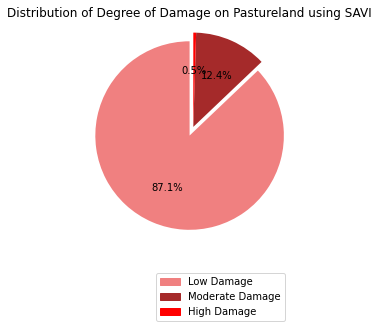

In [ ]:
#labels
labels = ['Low Damage','Moderate Damage','High Damage']

explode = (0.1, 0, 0)  # only "explode" the 2nd slice 
#plotting the piechart
fig1, ax1 = plt.subplots()
ax1.pie(Total_Degree_Pasture, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False,labeldistance = None,colors= ['lightcoral','brown','red'], startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Distribution of Degree of Damage on Pastureland using SAVI')

plt.legend(handles=patches, bbox_to_anchor=(0.4, -0.15), loc=2, borderaxespad=0. )

#plt.savefig('/content/drive/My Drive/Omdena Project/Visualizations_Damage_Assessment/degree_damage_pie_chart.png', dpi=200, bbox_inches='tight', pad_inches=0.7)
plt.show();

**Assessing the Degree of Damage for Forestland**

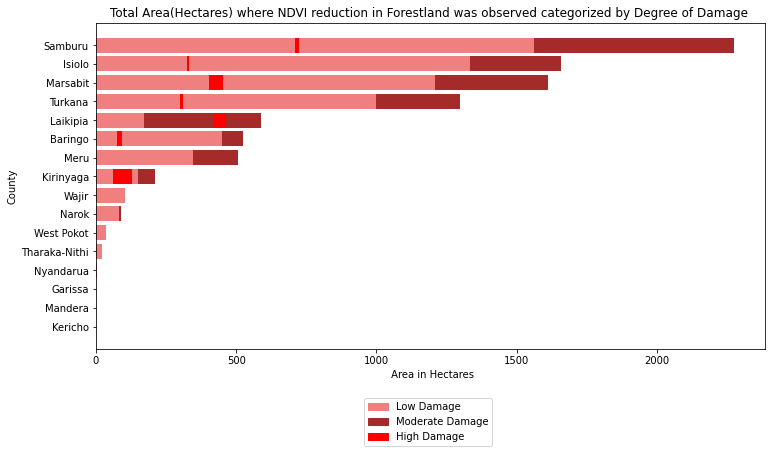

In [ ]:

# sorting the dataframe by total damage
county_df = county_df.sort_values('Total_Forestland(Ha)', ascending = True)

# creating a stacked bar plot visualization
fig = plt.figure(figsize = (12,6))
plt.barh(county_df.index, county_df['Low_Damage_Forestland(Ha)'],height = 0.8, color = 'lightcoral')
plt.barh(county_df.index, county_df['Moderate_Damage_Forestland(Ha)'],height = 0.8, left =county_df['Low_Damage_Forestland(Ha)'],color = 'brown')
plt.barh(county_df.index, county_df['High_Damage_Forestland(Ha)'],height = 0.8, left =county_df['Moderate_Damage_Forestland(Ha)'],color = 'red')

#labelling the figure
plt.title('Total Area(Hectares) where NDVI reduction in Forestland was observed categorized by Degree of Damage ')
plt.xlabel(' Area in Hectares')
plt.ylabel('County')

#creating a legend
plt.legend(handles=patches, bbox_to_anchor=(0.4, -0.15), loc=2, borderaxespad=0. )

plt.savefig('/content/drive/My Drive/Omdena Project/Visualizations_Damage_Assessment/Forestland_Damage.png', dpi=200, bbox_inches='tight', pad_inches=0.7)
plt.show();

In [ ]:
 Total_Degree_Forest = [county_df['Low_Damage_Forestland(Ha)'].sum(), county_df['Moderate_Damage_Forestland(Ha)'].sum(), county_df['High_Damage_Forestland(Ha)'].sum()]
 Total_Degree_Forest

[6471.859999999999, 2459.74, 217.24]

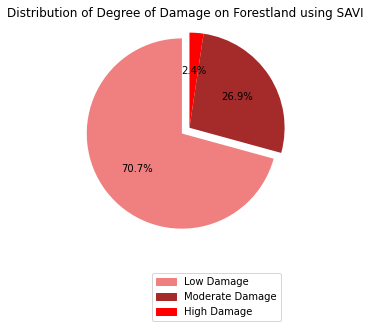

In [ ]:
#labels
labels = ['Low Damage','Moderate Damage','High Damage']

explode = (0.1, 0, 0)  # only "explode" the 2nd slice 
#plotting the piechart
fig1, ax1 = plt.subplots()
ax1.pie(Total_Degree_Forest, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False,labeldistance = None,colors= ['lightcoral','brown','red'], startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Distribution of Degree of Damage on Forestland using SAVI')
#creating a legend

plt.legend(handles=patches, bbox_to_anchor=(0.4, -0.15), loc=2, borderaxespad=0. )

#plt.savefig('/content/drive/My Drive/Omdena Project/Visualizations_Damage_Assessment/degree_damage_pie_chart.png', dpi=200, bbox_inches='tight', pad_inches=0.7)
plt.show();

**Assessing the Degree of Damage for all vegetation Classes**

In [ ]:
#Getting the total damage per on vegetation
Total_Low_Damage = county_df['Low_Damage_Cropland(Ha)'].sum() + county_df['Low_Damage_Pastureland(Ha)'].sum() + county_df['Low_Damage_Forestland(Ha)'].sum()
Total_Moderate_Damage = county_df['Moderate_Damage_Cropland(Ha)'].sum() + county_df['Moderate_Damage_Pastureland(Ha)'].sum() + county_df['Moderate_Damage_Forestland(Ha)'].sum()
Total_High_Damage = county_df['High_Damage_Cropland(Ha)'].sum() + county_df['High_Damage_Pastureland(Ha)'].sum() + county_df['High_Damage_Forestland(Ha)'].sum()
Total_Degree = [Total_Low_Damage,Total_Moderate_Damage,Total_High_Damage]
Total_Degree

[48990.21000000002, 9642.07, 962.34]

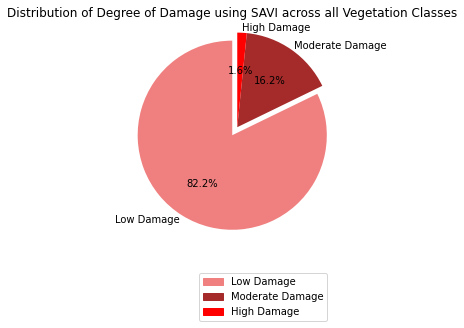

In [ ]:
#labels
labels = ['Low Damage','Moderate Damage','High Damage']

explode = (0.1, 0, 0)  # only "explode" the 2nd slice 
#plotting the piechart
fig1, ax1 = plt.subplots()
ax1.pie(Total_Degree, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False,labeldistance = 1.05,colors= ['lightcoral','brown','red'], startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Distribution of Degree of Damage using SAVI across all Vegetation Classes')

#creating a legend
plt.legend(handles=patches, bbox_to_anchor=(0.4, -0.15), loc=2, borderaxespad=0. )

#plt.savefig('/content/drive/My Drive/Omdena Project/Visualizations_Damage_Assessment/degree_damage_pie_chart.png', dpi=200, bbox_inches='tight', pad_inches=0.7)
plt.show();

### **Assumptions/Caveat**
1. The analysis did not consider the harvesting cycles and the effect it had on the SAVI difference.
2. The before and after images were taken with a maximum time differene of 15 days apart. Therefore, the assumption is that the time difference is too short for seasonal changes in vegetation to affect the vegetation indices.
3. In some pixels, increase in vegetation indices were observed in the after images.


### **Results**
1. The total area of land with a reduction of SAVI observed after the Locust attacks was 59,594.619 Ha
2. Pastureland had the highest reduction in NDVI accounting for 76.4% of the total area of land affected.
3. From the graphs, in all the vegetation types, most of the damage was of a lower degree; An SAVI difference of less than 0.2.- 82.2%
4. The most affected counties in terms of total area affected were:
  1. Turkana - 22,562.87 Ha
  2. Marsabit - 14,330.42 Ha
  3. Samburu - 9,108.72 Ha